In [1]:
import os
import glob
import numpy as np 
import xarray as xr
import pandas as pd
import datetime
from datetime import date, timedelta
import dask

# Plotting utils 
import matplotlib
import matplotlib.pyplot as plt 
import cartopy
import cartopy.crs as ccrs


In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [3]:
# - - - - - - - - - - - - - - - 
# Pre-process data while reading in 
# - - - - - - - - - - - - - - - 

def preprocess_atm(ds):
    ds         = cesm_correct_time(ds)
    dsSel      = ds[['SHFLX','LHFLX','PBLH']]
    return dsSel

def preprocess_lnd(ds):
    dsSel      = ds[['SOILWATER_10CM']]
    return dsSel

In [4]:
# --------------------------------------------------------
# Function to read requested variables from FLUXNET file. 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# 
# Inputs:  fileName --> Full path to FLUXNET data file 
#          varNames --> An array of variable names to be 
#                       retrieved from said data file. 
#                       NOTE: If you wish to retrieve *all* 
#                       variables, pass the string 'ALL'. 
#  
# Outputs: fluxnetID --> ID string used to identify station
#          fluxnetDS --> An x-array dataset containing the 
#                        requested variables.
#                        Missing values will be set to NaN. 
# 
# --------------------------------------------------------

def readFLUXNET_var(fileName, varNames): 
    # Get ID of station 
    startID   = fileName.find('FLX_')
    fluxnetID = fileName[startID+4:startID+10]
    
    # If this is taking a long time or you just want to know where in the stations you are, uncomment print statement
    # print('Reading in site - ', fluxnetID)
    
    # Read in CSV file containing data 
    dataDF = pd.read_csv(fileName)
    
    # Return ALL variables from dataDF if requested
    if varNames=='ALL':
        fluxnetDF = dataDF
        
        # Set any value that's missing to NaN (not -9999)
        fluxnetDF = fluxnetDF.replace(-9999, np.nan)

        
        # If time has been requested, reformat to pandas date index
        fluxnetDF['TIMESTAMP'] = pd.to_datetime(fluxnetDF['TIMESTAMP'].values, format='%Y%m%d')
        fluxnetDF = fluxnetDF.set_index(['TIMESTAMP'])
        
        # Convert dataframe to Xarray Dataset (required to use coupling metrics toolbox)
        #   NOTE: since current implementation doesn't use the pre-formatted CoMeT, might not need this step now
        fluxnetDS = fluxnetDF.to_xarray()
            
    # Reduce returned DF to contain only variables of interest  
    else:
        
        # Check that requested variables are available in specific file
        errCount = 0                       # Initialize flag for error 
        colNames = dataDF.columns.values   # Available variables in file 
        
        for iVar in range(len(varNames)):  # Check each variable individually
            if (varNames[iVar] in colNames)==False:
                # Turn on print statement for more verbose output
                # print('** ERROR: %13s   not contained in file for %8s  **' %(varNames[iVar], fluxnetID))
                
                # If any variable is not conatined in file, return a NaN 
                fluxnetDS = -999
                errCount  = errCount+1
                
        # If all the variables *are* available, isolate those in DF and return that
        if errCount == 0: 
            fluxnetDF = dataDF[varNames]
            
            # Set any value that's missing to NaN (not -999)
            fluxnetDF = fluxnetDF.replace(-9999, np.nan)
            
            # If time has been requested, reformat to pandas make index
            if ('TIMESTAMP' in varNames)==True:
                fluxnetDF['TIMESTAMP'] = pd.to_datetime(fluxnetDF['TIMESTAMP'].values, format='%Y%m%d')
                fluxnetDF = fluxnetDF.set_index(['TIMESTAMP'])
        
            # Convert dataframe to Xarray Dataset (required to use coupling metrics toolbox)
            fluxnetDS = fluxnetDF.to_xarray()
    
    return(fluxnetID, fluxnetDS)




In [5]:
'''
Inputs: xname -- controlling variable 
        yname -- responding variable
        ds    -- dataset containing xname and yname data 
        
This is pulled almost directly from Ahmed Tawfik's CI code here: 
        https://github.com/abtawfik/coupling-metrics/blob/new_version_1/src/comet/metrics/coupling_indices.py 
'''

def compute_couplingIndex_FLUXNET(xname,yname,ds):
    xday = ds[xname].groupby('TIMESTAMP.season')
    yday = ds[yname].groupby('TIMESTAMP.season')

    # Get the covariance of the two (numerator in coupling index)
    covarTerm = ((xday - xday.mean()) * (yday - yday.mean())).groupby('TIMESTAMP.season').sum() / xday.count()

    # Now compute the actual coupling index 
    couplingIndex = covarTerm/xday.std()

    
    return couplingIndex


In [6]:
'''
Inputs: xname -- controlling variable 
        yname -- responding variable
        ds    -- dataset containing xname and yname data 
        
This is pulled almost directly from Ahmed Tawfik's CI code here: 
        https://github.com/abtawfik/coupling-metrics/blob/new_version_1/src/comet/metrics/coupling_indices.py 
'''

def compute_couplingIndex_cesm(xname,yname,xDS,yDS):
    xday = xDS[xname].groupby('time.season')
    yday = yDS[yname].groupby('time.season')

    # Get the covariance of the two (numerator in coupling index)
    covarTerm = ((xday - xday.mean()) * (yday - yday.mean())).groupby('time.season').sum() / xday.count()

    # Now compute the actual coupling index 
    couplingIndex = covarTerm/xday.std()

    
    return couplingIndex


## Set up dask

In [7]:
import dask
dask.config.set({'logging.distributed': 'error'})

from dask_jobqueue import PBSCluster

# For Casper
cluster = PBSCluster(
    queue="casper",
    walltime="01:00:00",
    project="P93300042",
    memory="4GB",
    resource_spec="select=1:ncpus=1:mem=4GB",
    cores=1,
    processes=1,
)

from dask.distributed import Client

# Connect client to the remote dask workers
client = Client(cluster)
client

cluster.scale(8)

client.wait_for_workers(8)


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41745 instead
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for 

## Read in CESM runs and compute coupling index

In [8]:
testDir     = '/glade/derecho/scratch/ssfcst/archive/'

case_IDs  = [
               # '0.3',
               '0.5',
               '0.8',
               '1.0'
              ]

caseNames = [
               # 'cesm2cam6_land0.3_5yr',
               'cesm2cam6_land0.5_5yr',
               'cesm2cam6_land0.8_5yr',
               'cesm2cam6_land1.0_5yr']
    
for iCase in range(len(case_IDs)):
    print('*** Starting on case %s ***' % (case_IDs[iCase]))

    ## Select just the first thirty years 
    listFiles_atm = np.sort(glob.glob(testDir+caseNames[iCase]+'/atm/hist/*cam.h2.????-*'))
    listFiles_lnd = np.sort(glob.glob(testDir+caseNames[iCase]+'/lnd/hist/*clm2.h0.????-*'))
    
    ## Now read in those files
    case_atm = xr.open_mfdataset(listFiles_atm,  preprocess=preprocess_atm, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('atm files loaded')
    case_lnd = xr.open_mfdataset(listFiles_lnd,  preprocess=preprocess_lnd, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal')
    print('lnd files loaded')
    
    ## Add case ID (short name) to the DS
    case_atm      = case_atm.squeeze().assign_coords({"case":  case_IDs[iCase]})
    case_lnd      = case_lnd.squeeze().assign_coords({"case":  case_IDs[iCase]})
    
    ## Return all the cases in a single dataset
    if iCase==0:
        atmDS    = case_atm
        del case_atm
        lndDS = case_lnd
        del case_lnd
    else: 
        atmDS    = xr.concat([atmDS, case_atm], "case") 
        del case_atm
        lndDS = xr.concat([lndDS, case_lnd], "case") 
        del case_lnd
    

*** Starting on case 0.5 ***
atm files loaded
lnd files loaded
*** Starting on case 0.8 ***
atm files loaded
lnd files loaded
*** Starting on case 1.0 ***
atm files loaded
lnd files loaded


**Note:** It would probably be good to not just assing the soilwater variable to an atmDS, but to confirm that times are the same (those are probably fine to just set manually though), and that the latitudes match. 

In [9]:
# Make one big xr.Dataset containing all the information we need
dsFull = atmDS
dsFull['SOILWATER_10CM'] = (('case','time','lat','lon'), lndDS.SOILWATER_10CM.values)


In [10]:
cesm_TCI = compute_couplingIndex_cesm('SOILWATER_10CM','SHFLX',dsFull,dsFull)

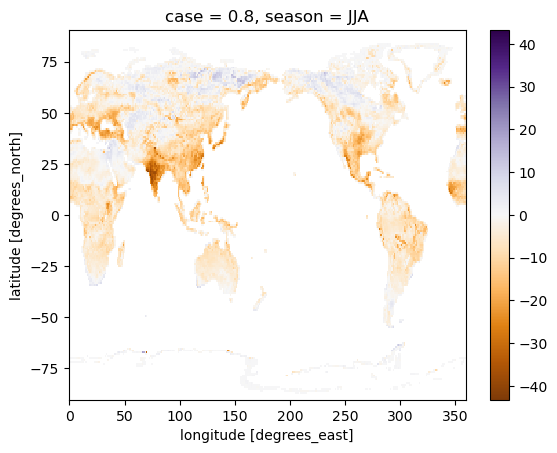

In [10]:

cesm_TCI.isel(case=0).sel(season='JJA').plot(cmap='PuOr')

In [11]:
cesm_ACI = compute_couplingIndex_cesm('SHFLX','PBLH',dsFull,dsFull)

In [12]:
xday = dsFull['SOILWATER_10CM'].groupby('time.season')
yday = dsFull['SHFLX'].groupby('time.season')

# Get the covariance of the two (numerator in coupling index)
covarTerm = ((xday - xday.mean()) * (yday - yday.mean())).groupby('time.season').sum() / xday.count()

# Now compute the actual coupling index 
couplingIndex = covarTerm/xday.std()


In [14]:
xday

DataArrayGroupBy, grouped over 'season'
4 groups with labels 'DJF', 'JJA', 'MAM', 'SON'.

In [17]:
((xday - xday.mean()) * (yday - yday.mean()))

<xarray.DataArray (case: 4, time: 1826, lat: 192, lon: 288)> Size: 2GB
dask.array<multiply, shape=(4, 1826, 192, 288), dtype=float32, chunksize=(1, 46, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 15kB 1999-01-04 00:00:00 ... 2004-01-03 12:00:00
  * case     (case) <U3 48B '0.3' '0.5' '0.8' '1.0'
    season   (time) object 15kB 'DJF' 'DJF' 'DJF' 'DJF' ... 'DJF' 'DJF' 'DJF'

In [16]:
((xday - xday.mean()))

<xarray.DataArray 'SOILWATER_10CM' (case: 4, time: 1826, lat: 192, lon: 288)> Size: 2GB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 15kB 1999-01-04 00:00:00 ... 2004-01-03 12:00:00
  * case     (case) <U3 48B '0.3' '0.5' '0.8' '1.0'
    season   (time) object 15kB 'DJF' 'DJF' 'DJF' 'DJF' ... 'DJF' 'DJF' 'DJF'

## Read in FLUXNET data and compute coupling index for stations

In [13]:
mainDir   = '/glade/campaign/cgd/tss/people/mdfowler/FLUXNET2015/'

## Metadata files
siteInfoFile = mainDir+'SiteList.csv'
siteInfoDF = pd.read_csv(siteInfoFile)

metadataFile = mainDir+'FLX_AA-Flx_BIF_ALL_20200501/FLX_AA-Flx_BIF_DD_20200501.csv'
metadataDF = pd.read_csv(metadataFile)

## List of all station files 
dataFiles = glob.glob(mainDir + 'FLX_*/*SUBSET_DD*')


In [14]:
# Set up a few empty arrays to save data into 
terraCI_fluxnet   = np.full([len(dataFiles), 4], np.nan)            # Dimensions of [nStations, seasons]
terraCI_fluxnetConverted   = np.full([len(dataFiles), 4], np.nan)   # CI using kg/m2 soil water content 

# Also save out some data on each station 
startTime_fluxnet = np.zeros(len(dataFiles), dtype='datetime64[s]')
endTime_fluxnet   = np.zeros(len(dataFiles), dtype='datetime64[s]')
lat_fluxnet       = np.full([len(dataFiles)], np.nan)
lon_fluxnet       = np.full([len(dataFiles)], np.nan)
SWCdepth          = np.full([len(dataFiles)], np.nan)

stationID           = []
stationID_converted = []

allStationID        = []
    
# Variables I want returned:
varNames = ['TIMESTAMP','H_F_MDS','SWC_F_MDS_1','SWC_F_MDS_1_QC']

# Loop over each station (data file)
for iStation in range(len(dataFiles)):
    
    # Read in data 
    # ----------------------------------------------------------
    fluxnetID,fluxnetDS = readFLUXNET_var(dataFiles[iStation], varNames)
    
    # Save lat and lon for this station 
    # ----------------------------------------------------------
    indStation            = np.where(fluxnetID==siteInfoDF['SITE_ID'])
    lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
    lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
    allStationID.append(fluxnetID)
    
    # Check that there was data saved for this particular site: 
    # ----------------------------------------------------------
    if (type(fluxnetDS)==int):
        print('No data for station: %8s' % fluxnetID)
    
    elif ( (np.all(np.isnan(fluxnetDS['H_F_MDS']))==True) | (np.all(np.isnan(fluxnetDS['SWC_F_MDS_1']))==True) ):
        print('No data for station: %8s' % fluxnetID)
        
    # If data is present: 
    # ----------------------------------------------------------
    else:        
        # Only consider where data is actually present for selected vars
        iReal      = np.where((np.isfinite(fluxnetDS['SWC_F_MDS_1'])==True) & 
                              (np.isfinite(fluxnetDS['H_F_MDS'])==True))[0]
        fluxnetDS  = fluxnetDS.isel(TIMESTAMP=iReal)
        
        stationID.append(fluxnetID)
        
        # Convert units from volumetric (%) to mass (kg/m2)
        # -------------------------------------------------
        #   Step 1: Convert from % to fraction
        fracSM = (fluxnetDS['SWC_F_MDS_1'].values)/100.0
        
        #    Step 2: Need to use depth of obs in conversion 
        metaData_station    = metadataDF[metadataDF.SITE_ID==fluxnetID]
        iSWC                = np.where(metaData_station.DATAVALUE=='SWC_F_MDS_1')[0]
        #  Some locations (5) have two depths 
        if len(iSWC)>1:             
            for iDepth in range(len(iSWC)): 
                SWC_DF   = metaData_station[iSWC[iDepth]:iSWC[iDepth]+4]
                
                depth    = np.asarray(SWC_DF[SWC_DF.VARIABLE=='VAR_INFO_HEIGHT'].DATAVALUE.values).astype(float)
                depthDay = np.asarray(SWC_DF[SWC_DF.VARIABLE=='VAR_INFO_DATE'].DATAVALUE.values).astype(int)
                depthDay = int(str(depthDay[0])[:8])  # Some weird ones have time attached; don't want that
                depthDay = pd.to_datetime(depthDay, format='%Y%m%d')
        
                # Keep deepest level as the depth for station 
                if iDepth==0:
                    SWCdepth[iStation] = depth 
                    convertSM = fracSM*1000.0*np.abs(depth)
                else: 
                    # Use date as break point for getting kg/m2 SWC
                    #  Eq: SWC_kgm2 = SWC_vol [m3/m3] * 1000 [kg/m3] * depth [m]
                    dateArr = pd.DatetimeIndex(fluxnetDS.TIMESTAMP.values)
                    iTime   = int(np.where(dateArr==depthDay)[0])
                    convertSM[iTime::] = (fracSM[iTime::])*1000.0*np.abs(depth)
                    
                    # Keep deepest level as the depth for station 
                    if depth<SWCdepth[iStation]: 
                        SWCdepth[iStation] = depth
                        
            stationID_converted.append(fluxnetID)
                
        # If station only has one level recorded, things are a bit easier:             
        else: 
            SWC_DF             = metaData_station[iSWC[0]:iSWC[0]+4]
            SWCdepth[iStation] = np.asarray(SWC_DF[SWC_DF.VARIABLE=='VAR_INFO_HEIGHT'].DATAVALUE.values).astype(float)
            convertSM          = fracSM*1000.0*np.abs(SWCdepth[iStation])
            
            stationID_converted.append(fluxnetID)

        # Save converted soil moisture to dataset 
        fluxnetDS['SWC_F_MDS_1_convert'] = (('TIMESTAMP'), convertSM)
        
        
        # Save first and last time used for computing CI 
        # ----------------------------------------------
        startTime_fluxnet[iStation] = fluxnetDS['TIMESTAMP'].values[0]
        endTime_fluxnet[iStation]   = fluxnetDS['TIMESTAMP'].values[-1]
                
        # Compute terrestrial coupling metric
        # -----------------------------------
        terraLeg = compute_couplingIndex_FLUXNET('SWC_F_MDS_1', 
                                                 'H_F_MDS',
                                                  fluxnetDS)

        terraLeg2 = compute_couplingIndex_FLUXNET('SWC_F_MDS_1_convert', 
                                                  'H_F_MDS',
                                                  fluxnetDS)
        
        # If there's less than one full year of data, don't use station
        #   (i.e., as long as all 4 seasons are defined, save values)
        if np.shape(terraLeg2)[0]==4:
            terraCI_fluxnet[iStation,:]          = terraLeg
            terraCI_fluxnetConverted[iStation,:] = terraLeg2
            

/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   US-Prr
No data for station:   US-Tw4


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SWCdepth[iStation] = np.asarray(SWC_DF[SWC_DF.VARIABLE=='VAR_INFO_HEIGHT'].DATAVALUE.values).astype(float)
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before p

No data for station:   AU-Cum


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   ES-Ln2
No data for station:   US-Ha1


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   BR-Sa1
No data for station:   FI-Lom


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   US-Cop


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   US-Atq
No data for station:   US-Wi4


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   CZ-wet


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SWCdepth[iStation] = np.asarray(SWC_DF[SWC_DF.VARIABLE=='VAR_INFO_HEIGHT'].DATAVALUE.values).astype(float)
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before p

No data for station:   GL-NuF


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SWCdepth[iStation] = np.asarray(SWC_DF[SWC_DF.VARIABLE=='VAR_INFO_HEIGHT'].DATAVALUE.values).astype(float)
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before p

No data for station:   US-GBT
No data for station:   US-Wi5


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   US-Los
No data for station:   DE-Akm


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SWCdepth[iStation] = np.asarray(SWC_DF[SWC_DF.VARIABLE=='VAR_INFO_HEIGHT'].DATAVALUE.values).astype(float)
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before p

No data for station:   NL-Hor
No data for station:   US-Wi6
No data for station:   BE-Bra


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   US-Ivo


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   DE-SfN


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SWCdepth[iStation] = np.asarray(SWC_DF[SWC_DF.VARIABLE=='VAR_INFO_HEIGHT'].DATAVALUE.values).astype(float)
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before p

No data for station:   AR-Vir
No data for station:   US-ORv


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SWCdepth[iStation] = np.asarray(SWC_DF[SWC_DF.VARIABLE=='VAR_INFO_HEIGHT'].DATAVALUE.values).astype(float)
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before p

No data for station:   US-Wi3
No data for station:   CA-Obs


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   US-Wi2
No data for station:   US-Wi9


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   DE-Spw


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   FR-Pue
No data for station:   US-Ne3
No data for station:   DE-RuS


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   DE-Zrk


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   CA-Man
No data for station:   US-Twt


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SWCdepth[iStation] = np.asarray(SWC_DF[SWC_DF.VARIABLE=='VAR_INFO_HEIGHT'].DATAVALUE.values).astype(float)
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before p

No data for station:   US-Wi7


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SWCdepth[iStation] = np.asarray(SWC_DF[SWC_DF.VARIABLE=='VAR_INFO_HEIGHT'].DATAVALUE.values).astype(float)
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before p

No data for station:   IT-La2
No data for station:   US-Wi1


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   US-Wi8


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   GL-ZaF
No data for station:   US-Myb


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   US-WPT


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   DE-RuR


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   FR-Fon
No data for station:   US-Ne2


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   CG-Tch


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SWCdepth[iStation] = np.asarray(SWC_DF[SWC_DF.VARIABLE=='VAR_INFO_HEIGHT'].DATAVALUE.values).astype(float)
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before p

No data for station:   RU-Che


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SWCdepth[iStation] = np.asarray(SWC_DF[SWC_DF.VARIABLE=='VAR_INFO_HEIGHT'].DATAVALUE.values).astype(float)
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before p

No data for station:   US-Tw1


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   RU-Cok


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   US-Wi0


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SWCdepth[iStation] = np.asarray(SWC_DF[SWC_DF.VARIABLE=='VAR_INFO_HEIGHT'].DATAVALUE.values).astype(float)
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before p

No data for station:   FI-Let


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

No data for station:   SJ-Adv


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SWCdepth[iStation] = np.asarray(SWC_DF[SWC_DF.VARIABLE=='VAR_INFO_HEIGHT'].DATAVALUE.values).astype(float)
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/3319182424.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before p

In [15]:
## Print some useful information 

print('Number of FLUXNET stations with CI calculated: %i' % len(np.where(np.isfinite(terraCI_fluxnet[:,1])==True)[0]))

# There should be three less valid stations for converted, becasue three stations list their depths as 0.0 meters. 
# These will be removed below 
print('Number of FLUXNET stations with CI calculated: %i' % len(np.where(np.isfinite(terraCI_fluxnetConverted[:,1])==True)[0]))

# How many months go into each calculation of CI for JJA? 
nMonths = np.full([len(dataFiles)], np.nan)

for iSt in range(len(dataFiles)):
    if np.isfinite(terraCI_fluxnet[iSt,1]):
        dateRange      = pd.date_range(start=startTime_fluxnet[iSt],end=endTime_fluxnet[iSt],freq='M')
        nMonths[iSt]   = len(np.where((dateRange.month>=6) & (dateRange.month<=8))[0])
        
print('Minimum number of months used for JJA mean CI: %i ' % int(np.nanmin(nMonths)) )
print('Maximum number of months used for JJA mean CI: %i ' % int(np.nanmax(nMonths)))


Number of FLUXNET stations with CI calculated: 153
Number of FLUXNET stations with CI calculated: 150
Minimum number of months used for JJA mean CI: 1 
Maximum number of months used for JJA mean CI: 57 


/glade/derecho/scratch/mdfowler/tmp/ipykernel_7437/731798290.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dateRange      = pd.date_range(start=startTime_fluxnet[iSt],end=endTime_fluxnet[iSt],freq='M')


*Make some choices on limiting which stations are used*
- Let's limit usage to depths less than 20 cm (arbitrary, but I don't want us using non-surface soil moisture for this application). This will eliminate 11 stations.
- It would also be good to put some time limits on this. So let's say the observations need to have at least 9 months of data for JJA means (3-years). Otherwise, set terraCI to np.nan again so we don't use it.

In [16]:
# Get stations with SWC from below 20 cm (or equal to zero)
iLimit = np.where((SWCdepth==0.0) | (SWCdepth<-0.2))[0]

# Set the terrestrial leg of CI to missing so we don't consider those 
terraCI_fluxnet[iLimit,:]          = np.nan
terraCI_fluxnetConverted[iLimit,:] = np.nan

print('Number of FLUXNET stations to use with reasonable depths of SWC: %i' % len(np.where(np.isfinite(terraCI_fluxnetConverted[:,1])==True)[0]))
print('Number of FLUXNET stations to use with reasonable depths of SWC_converted: %i' % len(np.where(np.isfinite(terraCI_fluxnet[:,1])==True)[0]))


# Get stations with less than 9 months used for JJA terrestrial CI 
iLimit = np.where(nMonths<9)[0]

# Set to missing so we don't consider stations with less than three years of data going into the average 
terraCI_fluxnet[iLimit,:] = np.nan
terraCI_fluxnetConverted[iLimit,:] = np.nan

print('Number of FLUXNET stations to use with 3+ years of JJA data: %i' % len(np.where(np.isfinite(terraCI_fluxnetConverted[:,1])==True)[0]))


Number of FLUXNET stations to use with reasonable depths of SWC: 139
Number of FLUXNET stations to use with reasonable depths of SWC_converted: 139
Number of FLUXNET stations to use with 3+ years of JJA data: 115


In [32]:
seasons = terraLeg.season

## Make plots of coupling index and add FLUXNET obs

In [18]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    
    import matplotlib as mpl
    import numpy as np
    
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap


In [25]:
### Create a list of RGB tuples for terrestrial leg (SM, SHFLX)
colorsList_SMvSHF = [(124,135,181), 
                     (107,109,161),
                     (51,82,120),
                     (49,114,127),
                     (97,181,89),
                     (200,218,102),
                     (255,242,116),
                     (238,164,58)] # This example uses the 8-bit RGB
my_cmap_SMvSHF = make_cmap(colorsList_SMvSHF, bit=True)

### Create a list of RGB tuples for atmospheric leg (SHFLX, P_lcl)
colorsList_SHFvPBLH = [(172,183,209), 
                     (124,135,181),
                     (51,82,120),
                     (97,181,89),
                     (200,218,102),
                     (255,242,116),
                     (238,164,58),
                     (136,90,59),
                     (214,48,44),
                     (224,93,126),
                     (242,189,177)] # This example uses the 8-bit RGB

my_cmap_SHFvPBLH = make_cmap(colorsList_SHFvPBLH, bit=True)

In [19]:
## A few plot options that are a bit more generic 
longrid, latgrid = np.meshgrid(cesm_TCI['lon'], cesm_TCI['lat'] )
norm_CI = matplotlib.colors.Normalize(vmin=-25, vmax=5)

levsPlot = [-20,-15,-10,-5,-2,-1,0] 


In [42]:
cesm_TCI.load()

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/apps/opt/conda/envs/n

<xarray.DataArray (case: 4, season: 4, lat: 192, lon: 288)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * case     (case) <U3 '0.3' '0.5' '0.8' '1.0'
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

Plot all the seasons

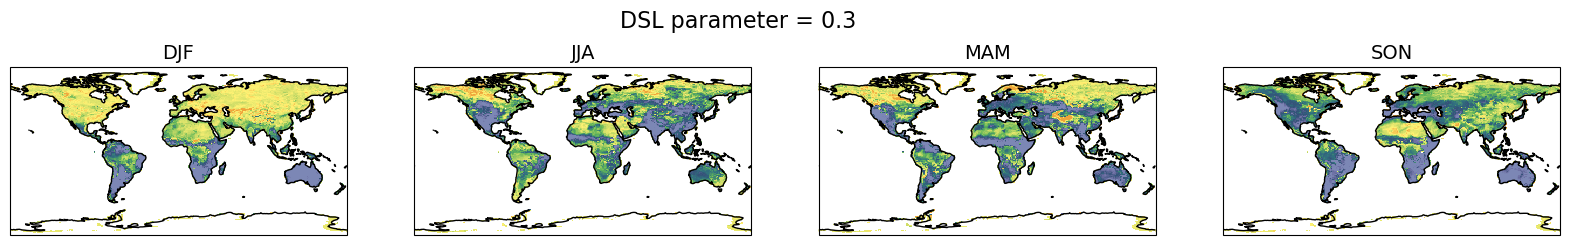

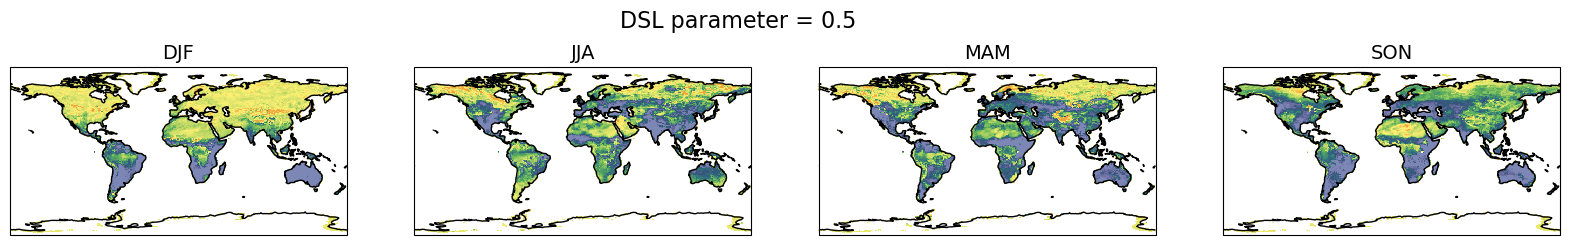

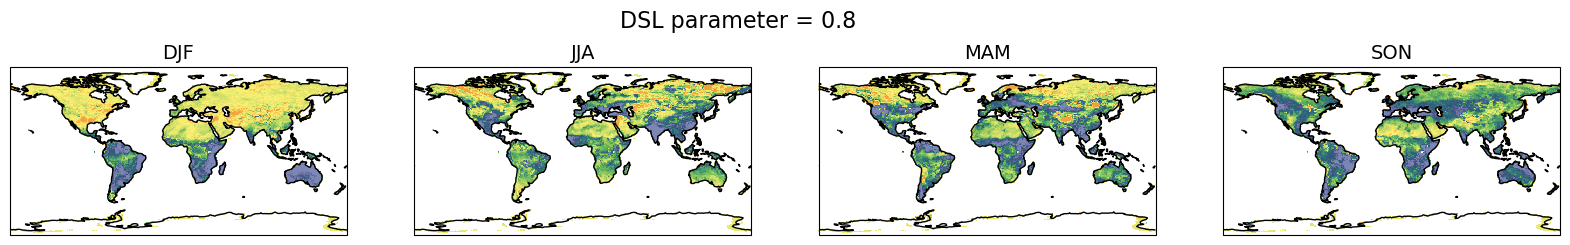

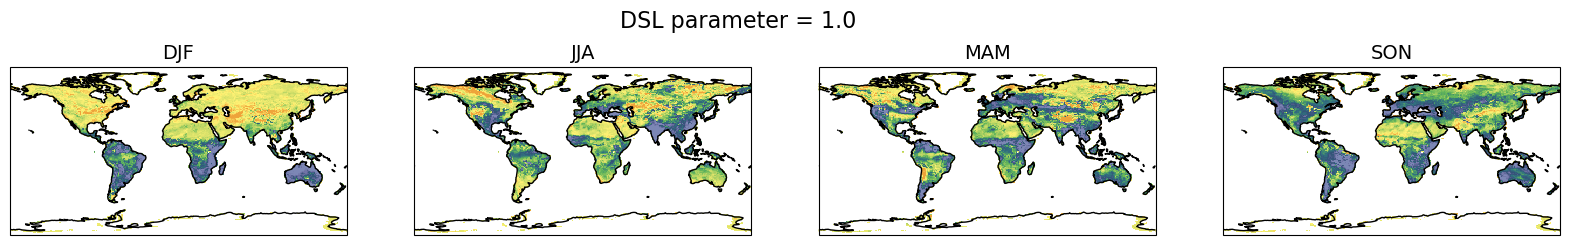

In [46]:
for iC in range(len(cesm_TCI.case)):

    fig,axs = plt.subplots(1,4,figsize=(20,13), subplot_kw={'projection':ccrs.PlateCarree()})
    axs     = axs.ravel() 
    
    plt.gcf().text(0.43, 0.59, 'DSL parameter = '+str(cesm_TCI.isel(case=iC).case.values), fontsize=16)

    for iS in range(4):
        axs[iS].pcolormesh(longrid,latgrid,cesm_TCI.isel(case=iC,season=iS).values, transform=ccrs.PlateCarree(), norm=norm_CI, cmap=my_cmap_SMvSHF)
        axs[iS].set_title(str(cesm_TCI.isel(case=iC,season=iS).season.values), fontsize=14)
    
    [a.coastlines() for a in axs]

    

/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/client.py:3245: UserWarning: Sending large graph of size 1.14 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/client.py:3245: UserWarning: Sending large graph of size 1.14 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


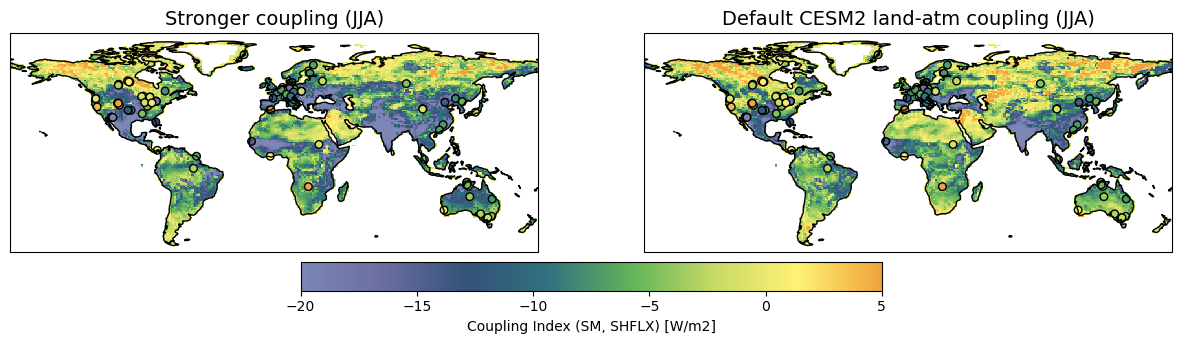

In [36]:
tci_jja = cesm_TCI.sel(season='JJA')

fig,axs = plt.subplots(1,2,figsize=(15,5), subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel() 

tci_jja_0p5 = tci_jja.sel(case='0.5')
tci_jja_0p8 = tci_jja.sel(case='0.8')

axs[1].pcolormesh(longrid,latgrid, tci_jja_0p8.values, transform=ccrs.PlateCarree(), norm=norm_CI, cmap=my_cmap_SMvSHF)
axs[1].set_title('Default CESM2 land-atm coupling (JJA)',fontsize=14)

p1 = axs[0].pcolormesh(longrid,latgrid, tci_jja_0p5.values, transform=ccrs.PlateCarree(), norm=norm_CI, cmap=my_cmap_SMvSHF)
axs[0].set_title('Stronger coupling (JJA)', fontsize=14)

# Add Colorbar
cb1 = fig.colorbar(p1, ax=axs, shrink=0.5, label='Coupling Index (SM, SHFLX) [W/m2]', orientation='horizontal', pad=0.025) 


[a.coastlines() for a in axs]
[a.set_extent([0,359,-60,89], crs=ccrs.PlateCarree()) for a in axs]

## Add FLUXNET obs
iSeason = np.where(seasons == 'JJA')[0]
iStations = np.where(
    np.isfinite(terraCI_fluxnetConverted[:, iSeason]) == True
)[0]
norm_CI = matplotlib.colors.Normalize(vmin=-20, vmax=5)

axs[0].scatter(
    lon_fluxnet[iStations],
    lat_fluxnet[iStations],
    c=terraCI_fluxnetConverted[iStations, iSeason],
    cmap=my_cmap_SMvSHF,
    norm=norm_CI,
    edgecolor="k",
    s=30,
    marker="o",
    transform=ccrs.PlateCarree(),
)

axs[1].scatter(
    lon_fluxnet[iStations],
    lat_fluxnet[iStations],
    c=terraCI_fluxnetConverted[iStations, iSeason],
    cmap=my_cmap_SMvSHF,
    norm=norm_CI,
    edgecolor="k",
    s=30,
    marker="o",
    transform=ccrs.PlateCarree(),
)

In [45]:
tci_jja.load()

/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/client.py:3245: UserWarning: Sending large graph of size 1.14 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<xarray.DataArray (case: 3, lat: 192, lon: 288)> Size: 1MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * case     (case) <U3 36B '0.5' '0.8' '1.0'
    season   <U3 12B 'JJA'

Text(0.05, 0.92, 'RMSE (StrongCoupling): 11.582359535106217')

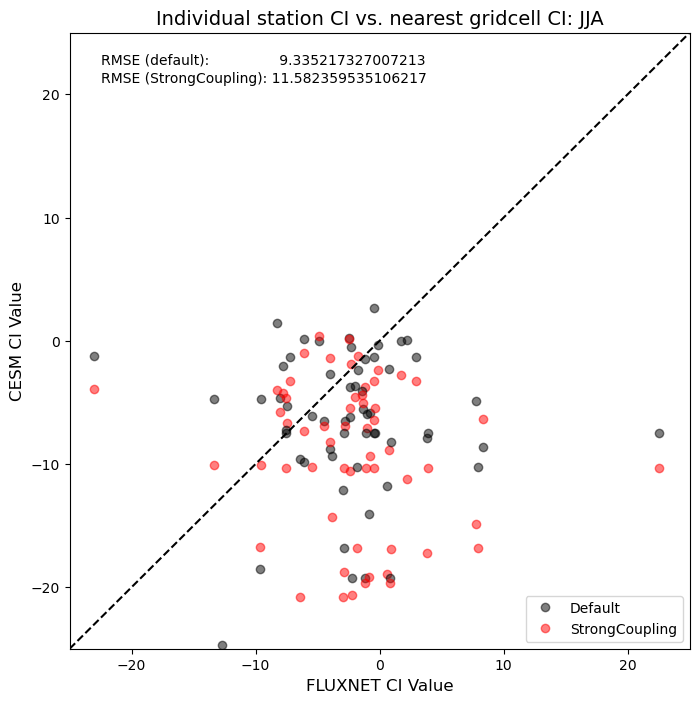

In [67]:
seasonstr = 'JJA'

fig, axs = plt.subplots(1, 1, figsize=(8, 8))

predictions_0p8 = []
predictions_0p5 = []
fluxnet_obs = [] 

iSeason = np.where(seasons == seasonstr)[0]
iStations = np.where(np.isfinite(terraCI_fluxnetConverted[:, iSeason]) == True)[0]

for iPoint in range(len(iStations)):
    this_lon = lon_fluxnet[iStations[iPoint]]  # lon1
    this_lat = lat_fluxnet[iStations[iPoint]]  # lat1

    # Find closest point in simulation 
    tci_jja_selPoint = tci_jja.sel(lat=this_lat, lon=this_lon, method='nearest')
    fluxnet_point    = terraCI_fluxnetConverted[iPoint, iSeason]
    

    if (np.all(np.isnan(tci_jja_selPoint.values)==False) & (np.isnan(fluxnet_point)==False) ): 

        predictions_0p8 = np.append(predictions_0p8, tci_jja_selPoint.sel(case='0.8').values)
        predictions_0p5 = np.append(predictions_0p5, tci_jja_selPoint.sel(case='0.5').values)
        fluxnet_obs = np.append(fluxnet_obs, fluxnet_point)
        
    
        axs.plot(terraCI_fluxnetConverted[iPoint, iSeason], 
                tci_jja_selPoint.sel(case='0.8').values,"ko", alpha=0.5)
        axs.plot(terraCI_fluxnetConverted[iPoint, iSeason], 
                tci_jja_selPoint.sel(case='0.5').values,"ro", alpha=0.5)
        axs.legend(['Default','StrongCoupling'])

axs.set_xlabel("FLUXNET CI Value", fontsize=12)
axs.set_ylabel("CESM CI Value", fontsize=12)
axs.set_title(
    "Individual station CI vs. nearest gridcell CI: " + seasonstr, fontsize=14
)
axs.set_xlim([-25, 25])
axs.set_ylim([-25, 25])
axs.plot(np.arange(-25, 26), np.arange(-25, 26), "k--")

rmse_0p8 = np.sqrt(
    ((predictions_0p8 - fluxnet_obs) ** 2).mean()
)

rmse_0p5 = np.sqrt(
    ((predictions_0p5 - fluxnet_obs) ** 2).mean()
)
axs.text(0.05, 0.95, "RMSE (default):                " + str(rmse_0p8), transform=axs.transAxes)
axs.text(0.05, 0.92, "RMSE (StrongCoupling): " + str(rmse_0p5), transform=axs.transAxes)


In [57]:
fluxnet_obs

array([         nan,          nan,          nan, -23.04595047,
        -8.25065878,  -9.67270433,   3.81728743, -12.68939406,
         1.68452605,          nan,  -1.99700307,  -7.19709868,
        -4.88118899,  -2.87030667,  -7.44659644,          nan,
                nan,          nan, -13.32248717,  -8.00127868,
                nan,          nan,  -6.10659637,          nan,
        -0.13724005,          nan,  -2.36535564,          nan,
        -5.45363728,   3.92784801,          nan,  -0.48658387,
                nan,  -2.31100079,          nan,  -1.02673504,
        -7.52355883,          nan,  -1.20354762,  -0.75707509,
                nan,  -6.07730908,   7.7607402 ,  -1.76115249,
        -1.86092161,          nan,  -9.5898849 ,  -0.42894532,
        -3.97265185,          nan,   8.30590341,          nan,
        -2.40943429,          nan,          nan,  -1.17394914,
                nan,   0.72195385,  -2.76558765,          nan,
         2.9046043 ,  22.49651027,  -1.38628146,       

In [ ]:
def plotScatter(seasonstr, caseSel=None):
    node_lats = uxgrid.face_lat.values
    node_lons = uxgrid.face_lon.values

    predictions = []

    fig, axs = plt.subplots(1, 1, figsize=(8, 8))

    CI_model = couplingIndex_DS["CouplingIndex"].sel(season=seasonstr)

    iSeason = np.where(seasons == seasonstr)[0]
    iStations = np.where(np.isfinite(terraCI_fluxnetConverted[:, iSeason]) == True)[0]

    for iPoint in range(len(iStations)):
        this_lon = lon_fluxnet[iStations[iPoint]]  # lon1
        this_lat = lat_fluxnet[iStations[iPoint]]  # lat1
        obs_point = np.array((this_lon, this_lat))

        # Get subset of relevant points
        i = np.where(
            (node_lats >= (this_lat - 2))
            & (node_lats <= (this_lat + 2))
            & (node_lons >= (this_lon - 2))
            & (node_lons <= (this_lon + 2))
        )[0]

        minDistance = 100
        for iSelClose in range(len(i)):
            # Find point in uxarray? Use euclidian distance
            distance = np.linalg.norm(
                obs_point - np.array((node_lons[i[iSelClose]], node_lats[i[iSelClose]]))
            )

            if (distance < minDistance) & (
                np.isfinite(
                    couplingIndex_DS["CouplingIndex"]
                    .sel(season="JJA")
                    .values[i[iSelClose]]
                )
                == True
            ):
                minDistance = distance
                selLon = node_lons[i[iSelClose]]
                selLat = node_lats[i[iSelClose]]
                selLoc = i[iSelClose]

        predictions = np.append(
            predictions,
            couplingIndex_DS["CouplingIndex"].sel(season=seasonstr).values[selLoc],
        )
        axs.plot(
            terraCI_fluxnetConverted[iPoint, iSeason],
            couplingIndex_DS["CouplingIndex"].sel(season=seasonstr).values[selLoc],
            "bo",
            alpha=0.5,
        )

    axs.set_xlabel("FLUXNET CI Value", fontsize=12)
    axs.set_ylabel("CESM CI Value", fontsize=12)
    axs.set_title(
        "Individual station CI vs. nearest gridcell CI: " + seasonstr, fontsize=14
    )
    axs.set_xlim([-25, 25])
    axs.set_ylim([-25, 25])
    axs.plot(np.arange(-25, 26), np.arange(-25, 26), "k--")

    rmse = np.sqrt(
        ((predictions - terraCI_fluxnetConverted[iStations, iSeason]) ** 2).mean()
    )
    axs.text(0.05, 0.95, "RMSE: " + str(rmse), transform=axs.transAxes)

    return axs

Plot JJA and DJF only (mostly what we look at)

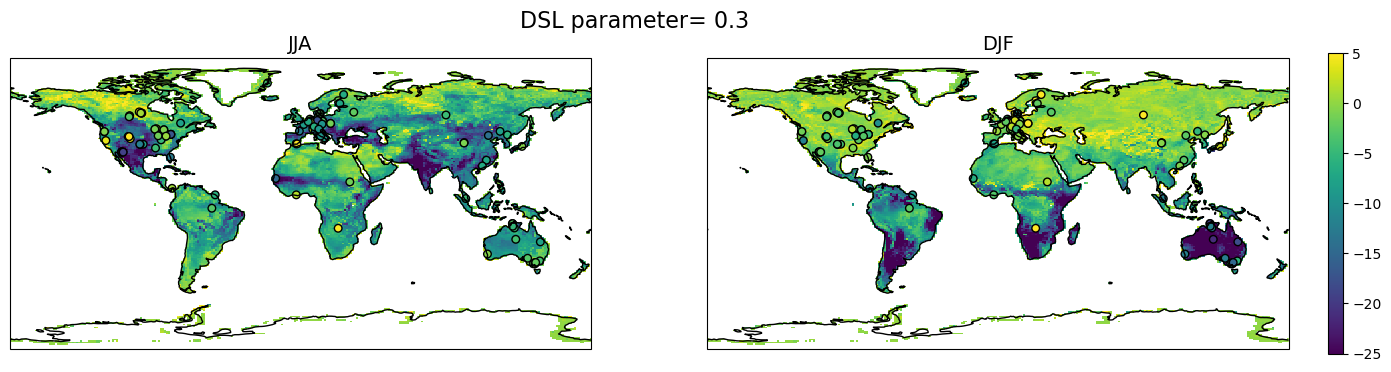

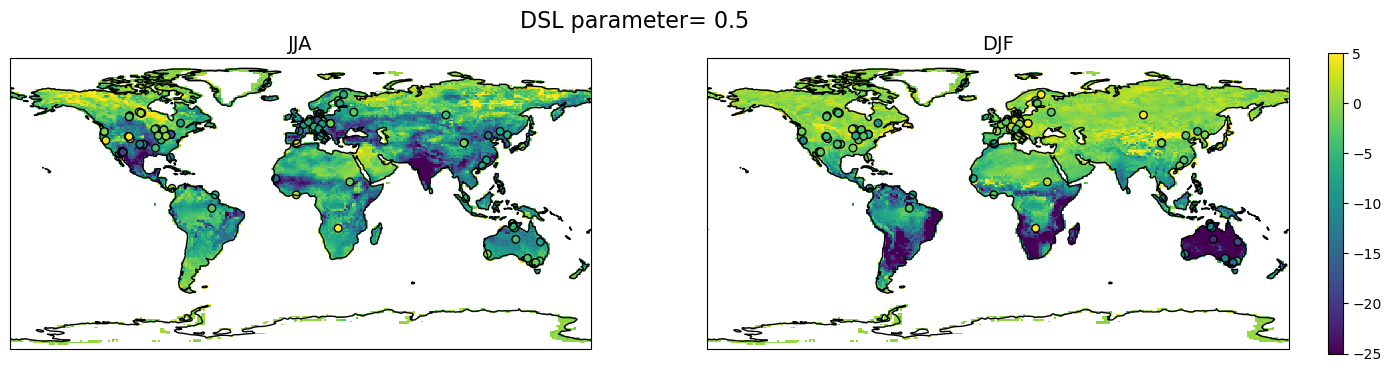

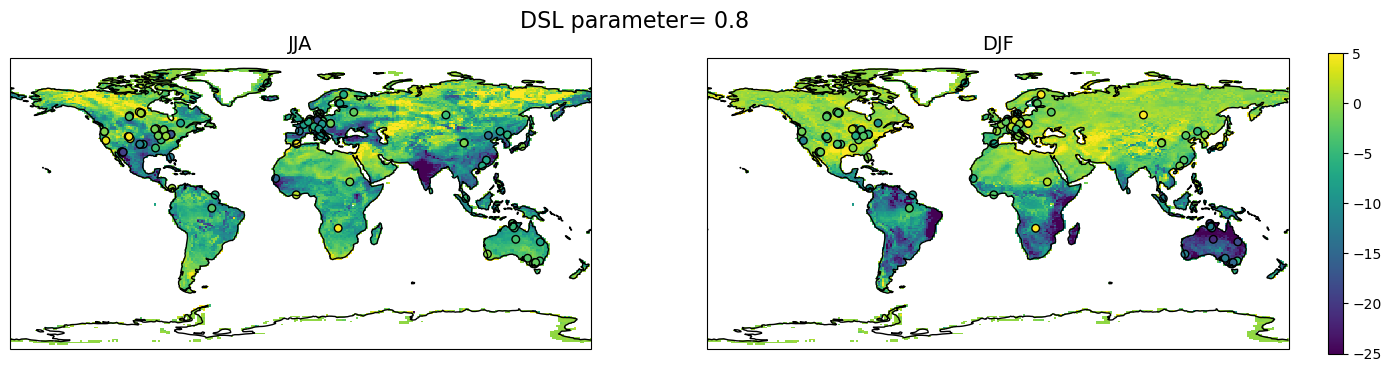

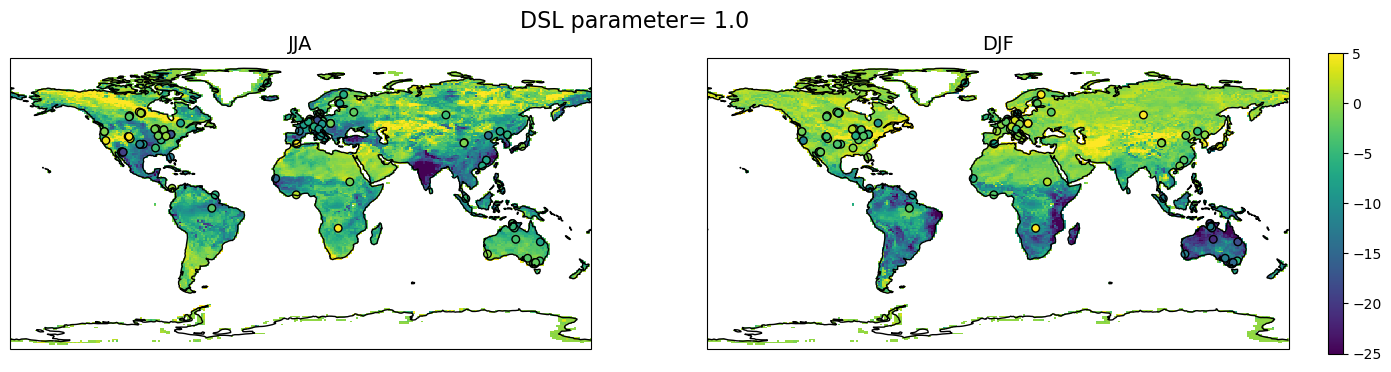

In [69]:
for iC in range(len(cesm_TCI.case)):

    fig,axs = plt.subplots(1,2,figsize=(20,13), subplot_kw={'projection':ccrs.PlateCarree()})
    axs     = axs.ravel() 
    
    plt.gcf().text(0.38, 0.63, 'DSL parameter= '+str(cesm_TCI.isel(case=iC).case.values), fontsize=16)

    axs[0].pcolormesh(longrid,latgrid, cesm_TCI.isel(case=iC).sel(season='JJA').values, transform=ccrs.PlateCarree(), norm=norm_CI, cmap='viridis')
    axs[0].set_title(str(cesm_TCI.isel(case=iC).sel(season='JJA').season.values), fontsize=14)

    img2 = axs[1].pcolormesh(longrid,latgrid,cesm_TCI.isel(case=iC).sel(season='DJF').values, transform=ccrs.PlateCarree(), norm=norm_CI, cmap='viridis')
    axs[1].set_title(str(cesm_TCI.isel(case=iC).sel(season='DJF').season.values), fontsize=14)

    # Add Colorbar
    cb1 = fig.colorbar(img2, ax=axs, shrink=0.30, label='', orientation='vertical', pad=0.025) 
    
    [a.coastlines() for a in axs]

    ## -----------------------------------------------------------
    ## Add FLUXNET obs 
    ## -----------------------------------------------------------
    
    # Plot observation points
    iJJA = np.where(cesm_TCI.season.values=='JJA')[0]
    iStations = np.where(np.isfinite(terraCI_fluxnetConverted[:,iJJA])==True)[0]
    
    axs[0].scatter(lon_fluxnet[iStations], lat_fluxnet[iStations], c=terraCI_fluxnetConverted[iStations,iJJA], cmap='viridis', norm=norm_CI,
                    edgecolor='k', s=30, marker='o', transform=ccrs.PlateCarree())

    iDJF = np.where(cesm_TCI.season.values=='DJF')[0]
    iStations2 = np.where(np.isfinite(terraCI_fluxnetConverted[:,iDJF])==True)[0]
    
    axs[1].scatter(lon_fluxnet[iStations2], lat_fluxnet[iStations2], c=terraCI_fluxnetConverted[iStations2,iDJF], cmap='viridis', norm=norm_CI,
                    edgecolor='k', s=30, marker='o', transform=ccrs.PlateCarree())



In [21]:
# ## A few plot options that are a bit more generic 
# longrid, latgrid = np.meshgrid(cesm_TCI['lon'], cesm_TCI['lat'] )
# norm_CI = matplotlib.colors.Normalize(vmin=-40, vmax=40)

# # levsPlot = [-20,-15,-10,-5,-2,-1,0] 


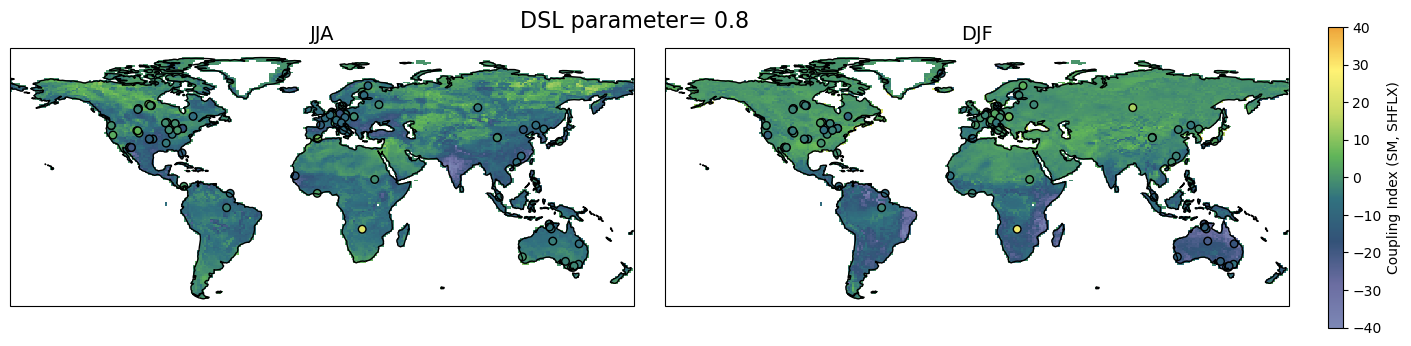

In [ ]:
for iC in range(len(cesm_TCI.case)):

    fig,axs = plt.subplots(1,2,figsize=(20,13), subplot_kw={'projection':ccrs.PlateCarree()})
    axs     = axs.ravel() 
    
    plt.gcf().text(0.38, 0.61, 'DSL parameter= '+str(cesm_TCI.isel(case=iC).case.values), fontsize=16)

    axs[0].pcolormesh(longrid,latgrid, cesm_TCI.isel(case=iC).sel(season='JJA').values, transform=ccrs.PlateCarree(), norm=norm_CI, 
                      cmap=my_cmap_SMvSHF )
                      # cmap='PuOr')
    axs[0].set_title(str(cesm_TCI.isel(case=iC).sel(season='JJA').season.values), fontsize=14)

    img2 = axs[1].pcolormesh(longrid,latgrid,cesm_TCI.isel(case=iC).sel(season='DJF').values, transform=ccrs.PlateCarree(), norm=norm_CI, 
                             cmap=my_cmap_SMvSHF )
                             # cmap='PuOr')
    axs[1].set_title(str(cesm_TCI.isel(case=iC).sel(season='DJF').season.values), fontsize=14)

    fig.subplots_adjust(wspace=0.05)


    # Add Colorbar
    cb1 = fig.colorbar(img2, ax=axs, shrink=0.30, label='Coupling Index (SM, SHFLX)', orientation='vertical', pad=0.025) 
    
    [a.coastlines() for a in axs]
    [a.set_extent([0,359,-60,89], crs=ccrs.PlateCarree()) for a in axs]


    ## -----------------------------------------------------------
    ## Add FLUXNET obs 
    ## -----------------------------------------------------------
    
    # Plot observation points
    iJJA = np.where(cesm_TCI.season.values=='JJA')[0]
    iStations = np.where(np.isfinite(terraCI_fluxnetConverted[:,iJJA])==True)[0]
    
    axs[0].scatter(lon_fluxnet[iStations], lat_fluxnet[iStations], c=terraCI_fluxnetConverted[iStations,iJJA],  norm=norm_CI,
                   cmap=my_cmap_SMvSHF,
                    # cmap='PuOr',
                    edgecolor='k', s=30, marker='o', transform=ccrs.PlateCarree())

    iDJF = np.where(cesm_TCI.season.values=='DJF')[0]
    iStations2 = np.where(np.isfinite(terraCI_fluxnetConverted[:,iDJF])==True)[0]
    
    axs[1].scatter(lon_fluxnet[iStations2], lat_fluxnet[iStations2], c=terraCI_fluxnetConverted[iStations2,iDJF],  norm=norm_CI,
                   cmap=my_cmap_SMvSHF,
                    # cmap='PuOr',
                    edgecolor='k', s=30, marker='o', transform=ccrs.PlateCarree())

    # plt.savefig('Figures/'+str(cesm_TCI.isel(case=iC).case.values)+'_TerrCouplingIndex.jpg', format='jpg', dpi=300, bbox_inches='tight')
    plt.show()
    

**Atmospheric Leg**

In [36]:
## A few plot options that are a bit more generic 
longrid, latgrid = np.meshgrid(cesm_ACI['lon'], cesm_ACI['lat'] )
norm_CI = matplotlib.colors.Normalize(vmin=-100, vmax=225)

levsPlot = [-100,-75,-50,-25,0,25,50,75,100,125,150,175,200,225] 


In [24]:
landFrac = np.copy(cesm_TCI.isel(case=0,season=1))
landFrac[np.isfinite(landFrac)] = 1

/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/client.py:3245: UserWarning: Sending large graph of size 1.51 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


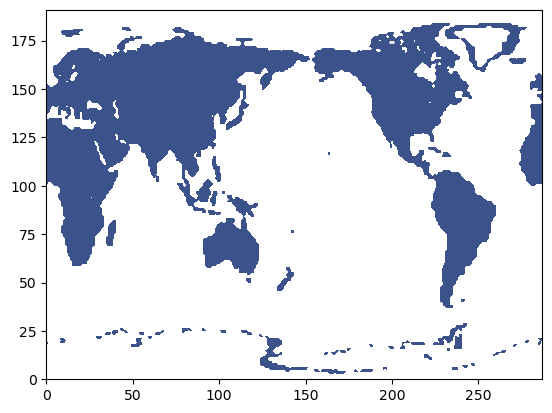

In [27]:
plt.contourf(landFrac)

In [ ]:
cesm_ACI.load()

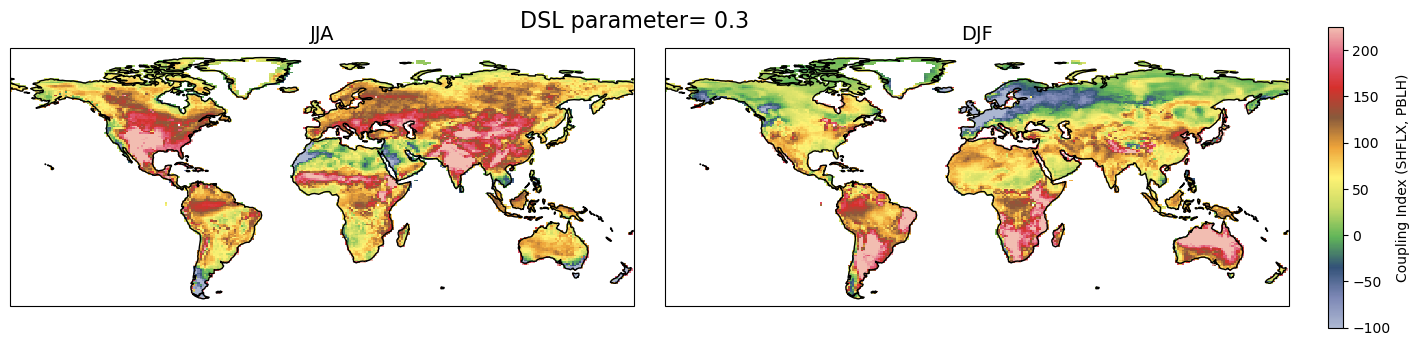

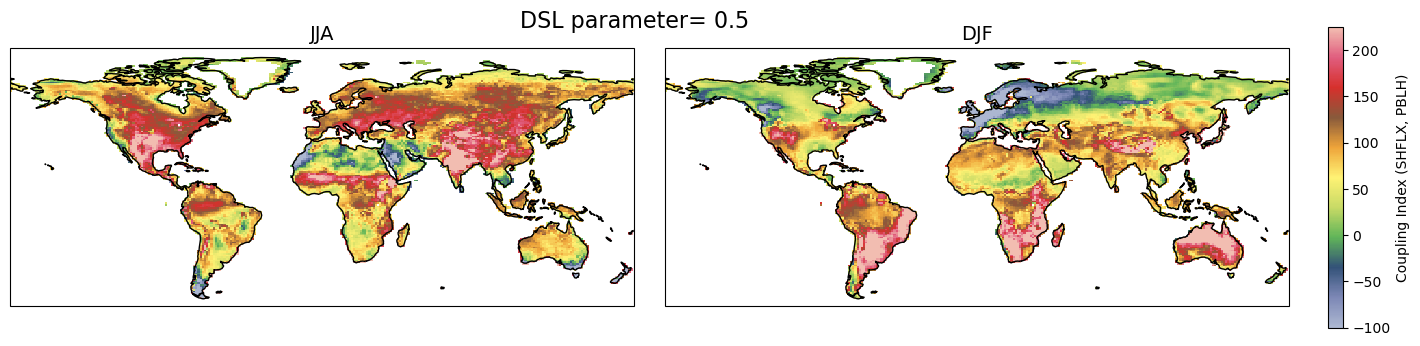

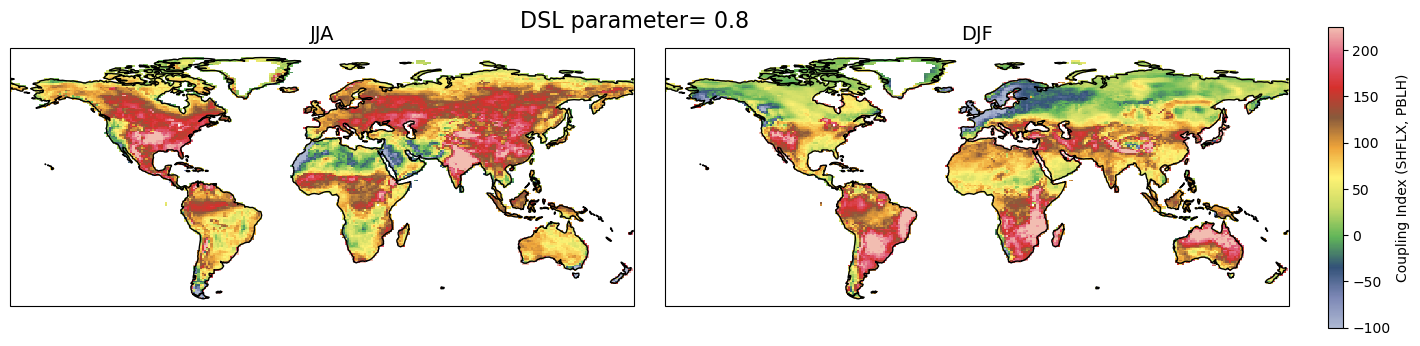

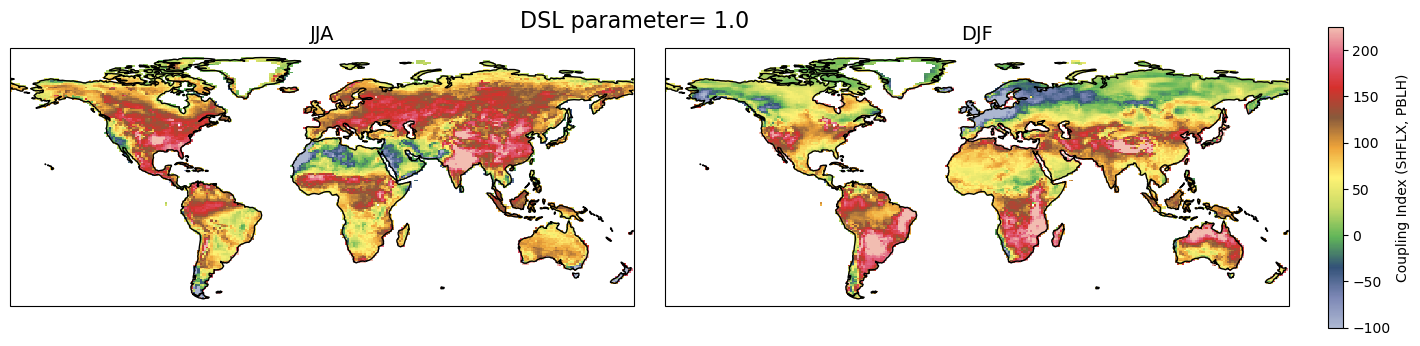

In [37]:
for iC in range(len(cesm_ACI.case)):

    fig,axs = plt.subplots(1,2,figsize=(20,13), subplot_kw={'projection':ccrs.PlateCarree()})
    axs     = axs.ravel() 
    
    plt.gcf().text(0.38, 0.61, 'DSL parameter= '+str(cesm_ACI.isel(case=iC).case.values), fontsize=16)

    axs[0].pcolormesh(longrid,latgrid, landFrac * cesm_ACI.isel(case=iC).sel(season='JJA').values,
                      transform=ccrs.PlateCarree(), norm=norm_CI, cmap=my_cmap_SHFvPBLH)
    axs[0].set_title(str(cesm_ACI.isel(case=iC).sel(season='JJA').season.values), fontsize=14)

    img2 = axs[1].pcolormesh(longrid,latgrid, landFrac * cesm_ACI.isel(case=iC).sel(season='DJF').values, 
                             transform=ccrs.PlateCarree(), norm=norm_CI, cmap=my_cmap_SHFvPBLH)
    axs[1].set_title(str(cesm_ACI.isel(case=iC).sel(season='DJF').season.values), fontsize=14)

    fig.subplots_adjust(wspace=0.05)


    # Add Colorbar
    cb1 = fig.colorbar(img2, ax=axs, shrink=0.30, label='Coupling Index (SHFLX, PBLH)', orientation='vertical', pad=0.025) 
    
    [a.coastlines() for a in axs]
    [a.set_extent([0,359,-60,89], crs=ccrs.PlateCarree()) for a in axs]



## Some measure of performance? 
Let's compute the RMSE over all points that are found to have valid coupling data. <br><br>
So for each FLUXNET station, we need to: <br>
(1) check that it has CI data; <br>
(2) get the lat/lon of the model gridcell that contains the tower; and <br>
(3) take the difference between modeled and observed terrestrial CI. <br> <br>
From there, we square the differences at each site, sum them all together, and divide by the number of sites used. 

In [74]:
# Define empty arrays to save differences in 
terraCI_ObsDiff = np.full([len(cesm_TCI.case.values), len(dataFiles)], np.nan)

# Count number of stations used...
nValidStation_case = np.zeros([len(cesm_TCI.case.values)])

# Save lat/lon for model output
latModel = cesm_TCI.lat.values
lonModel = cesm_TCI.lon.values
season   = cesm_TCI.season.values

iJJA = np.where(cesm_TCI.season.values=='JJA')[0]


# Consider each station individually 
for iCase in range(len(cesm_TCI.case.values)):
    # Count number of stations used...
    
    for iStation in range(len(dataFiles)):
        
        # Isolate station CI for JJA
        fluxnetCI = terraCI_fluxnetConverted[iStation,iJJA]
    
        # Check that there's data here (and at least 3 months went into JJA avg CI)
        # ------------------------------------------------------------------------
        if ( (np.isnan(fluxnetCI)==False) ): 
            
            # Get model gridcells that match fluxnet site 
            iLat        = np.where( (latModel>=(lat_fluxnet[iStation]-0.4712)) & 
                                    (latModel<=(lat_fluxnet[iStation]+0.4712)) )[0]
             # Convert longitude of point into 0-360 range 
            lonSel_flux = (lon_fluxnet[iStation] + 360) % 360                
            iLon        = np.where( (lonModel>=(lonSel_flux-0.625)) & 
                                    (lonModel<=(lonSel_flux+0.625)) )[0]
            
            gridValue_case = cesm_TCI.isel(case=iCase).sel(season='JJA')[iLat,iLon]
            
            # Compare to fluxnet-based estimate
            terraCI_ObsDiff[iCase, iStation] = gridValue_case - fluxnetCI
            
            # Increment counter for number of stations used 
            nValidStation_case[iCase] =  nValidStation_case[iCase]+1
        

In [84]:
print('        # Valid         RMSE        Mean abs bias,    Mean bias ')
print('Case    Stations  (model vs. obs)  (|model - obs|)  (model - obs)')
for iCase in range(len(cesm_TCI.case.values)):
    RMSE_case = np.sqrt(np.nansum(terraCI_ObsDiff[iCase,:]**2) / nValidStation_case[iCase])

    print('%4s %8i %13.3f %16.3f %16.3f' % (str(cesm_TCI.isel(case=iCase).case.values), 
                                            nValidStation_case[iCase], RMSE_case,
                                            np.nanmean(np.abs(terraCI_ObsDiff[iCase,:])), 
                                            np.nanmean(terraCI_ObsDiff[iCase,:])) )



        # Valid         RMSE        Mean abs bias,    Mean bias 
Case    Stations  (model vs. obs)  (|model - obs|)  (model - obs)
 0.3      115         8.953            6.958           -3.907
 0.5      115         8.742            6.699           -4.002
 0.8      115         7.820            5.712           -1.488
 1.0      115         8.055            5.993           -1.514
